In [1]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

In [2]:
data = pd.read_csv('train.csv')
data = data.drop(columns=['id'])
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [3]:
data.shape

(31962, 2)

In [4]:
def lowercase(text):
    text = text.lower()
    return text

def remove_punction(text):
    text = re.sub(r'[^a-z0-9 ]+', '', text)
    return text
    
def only_letters(text):
    text = re.sub(r'[^a-z ]', '', text)
    return text

def remove_spam(text):
    text = re.sub(r'\&\S+\;', '', text)
    return text
    
def format_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

def remove_user(text):
    text = re.sub(r'\@[^\s]+', '', text)
    return text

def remove_hashtag(text):
    text = re.sub(r'\#[^\s]+', '', text)
    return text

def remove_link(text):
    text = re.sub(r'https?[^\s]+', '', text)
    text = re.sub(r'www\.[^\s]+', '', text)
    text = re.sub(r'www\s?[^\s]+\s?com', '', text)
    return text

def remove_stopwords(text):
    words = text.split(' ')
    no_stopwords = [word for word in words if word not in stop_words]
    return ' '.join(no_stopwords)

def preprocessing(data):
    data = pd.Series(data)
    data = data.apply(str)
    data = data.apply(lowercase)
    data = data.apply(remove_user)
    data = data.apply(remove_link)
    data = data.apply(remove_spam)
    data = data.apply(remove_punction)
    data = data.apply(only_letters)
    data = data.apply(remove_stopwords)
    data = data.apply(format_text)
    return data

In [5]:
data.shape

(31962, 2)

Text(0, 0.5, 'count')

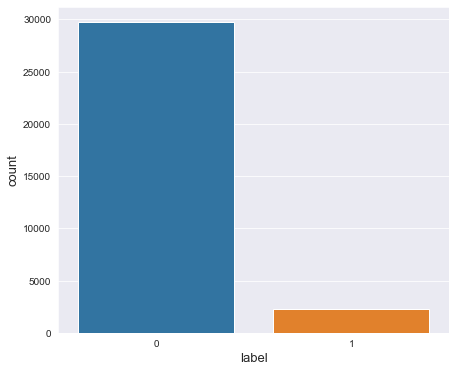

In [6]:
plt.figure(figsize=(7, 6))
sns.countplot(data=data, x='label')
plt.xlabel('label', fontsize=13)
plt.ylabel('count', fontsize=13)

In [7]:
%%time
data['cleaned_tweet'] = data['tweet'].apply(lowercase)
data.head()

CPU times: user 38.5 ms, sys: 505 µs, total: 39 ms
Wall time: 38.1 ms


,label,tweet,cleaned_tweet
0,0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation


## Text Augmentation

In [8]:
def text_augmentation(data, model):
    
    model = model.lower()
    
    if model == 'randomoversampler' or model == 'random over sampler':
        #over sampling
        ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
        X_resampled, y_resampled = ros.fit_resample(data[['cleaned_tweet']], data['label'])
        data_resampled = pd.concat([X_resampled, y_resampled], axis=1)
        return data_resampled
    elif model == 'smote':
        smote = SMOTE(random_state=42, sampling_strategy='minority')
        X_resampled, y_resampled = smote.fit_resample(data[['cleaned_tweet']], data['label'])
        data_resampled = pd.concat([X_resampled, y_resampled], axis=1)
        return data_resampled
    elif model == 'smotetomek' or model == 'smote tomek':
        tomek = SMOTETomek(random_state=42)
        X_resampled, y_resampled = tomek.fit_resample(data[['cleaned_tweet']], data['label'])
        data_resampled = pd.concat([X_resampled, y_resampled], axis=1)
        return data_resampled
    elif model == 'nlpaug':
        aug_texts = []
        minority_data = data[data['label'] == 1]
        aug = naw.SynonymAug(aug_src='wordnet')
        augmented_texts = aug.augment(minority_data['cleaned_tweet'].tolist(), n=15)
        
        for text in augmented_texts:
            aug_texts.append(text)
        
        temp = pd.DataFrame({
            'tweet': aug_texts
        })
        
        temp['label'] = 1
        
        data = pd.concat([data, temp], axis=0)
        data = data.reset_index()
        data = data.drop(columns=['index'])
        del temp, minority_data
        return data

## Processing

In [9]:
def processing(X_train, X_test):
    
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    vocab_size = len(tokenizer.word_index) + 1

    maxlen = 100

    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
    
    return X_train, X_test, vocab_size, tokenizer

## Creating the model

In [10]:
def create_model(vocab_size):
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=50, 
                               input_length=100))
    model.add(layers.Conv1D(64, 5, activation='relu', padding='same'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## Plot

In [11]:
def plot_model(model):
    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

## Submission

In [12]:
def submission(model, tokenizer, name):
    test = pd.read_csv('test.csv')
    test_id = test['id']
    test = test.drop(columns=['id'])
    test['tweet'] = test['tweet'].apply(lowercase)
    
    test = tokenizer.texts_to_sequences(test['tweet'])
    test = pad_sequences(test, padding='post', maxlen=100)
    
    prediction = (model.predict(test) > 0.5).astype("int32")
    predict = [int(p) for p in prediction]
    
    submission = pd.DataFrame({
        'id': test_id,
        'label': predict
    })

    submission.to_csv(name, index=False)

### Random Over Sampler

In [13]:
data = pd.read_csv('train.csv')
data = data.drop(columns=['id'])

In [14]:
%%time
data['cleaned_tweet'] = data['tweet'].apply(lowercase)
data.head()

CPU times: user 33 ms, sys: 0 ns, total: 33 ms
Wall time: 34 ms


,label,tweet,cleaned_tweet
0,0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation


In [15]:
data_resampled = text_augmentation(data, 'randomoversampler')
data.head()

,label,tweet,cleaned_tweet
0,0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation


In [16]:
data_resampled.shape

(59440, 2)

Text(0, 0.5, 'count')

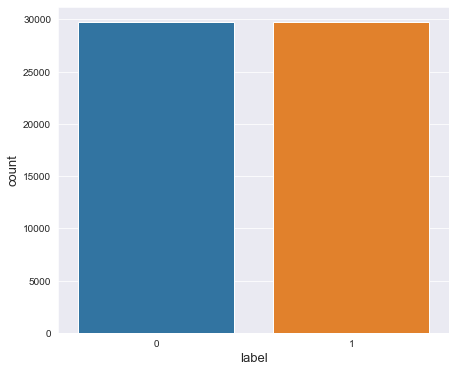

In [17]:
plt.figure(figsize=(7, 6))
sns.countplot(data=data_resampled, x='label')
plt.xlabel('label', fontsize=13)
plt.ylabel('count', fontsize=13)

In [18]:
data_resampled['label'].value_counts()

0    29720
1    29720
Name: label, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled['cleaned_tweet'],
                                                    data_resampled['label'],
                                                    test_size=0.2,
                                                    random_state=23)

In [20]:
X_train, X_test, max_len, tokenizer = processing(X_train, X_test)

In [21]:
model = create_model(max_len)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           1996400   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 64)           16064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,012,529
Trainable params: 2,012,529
Non-trainable params: 0
_________________________________________________________________


In [22]:
%%time
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
4756/4756 [==============================] - 183s 36ms/step - loss: 0.2488 - accuracy: 0.8936 - val_loss: 0.0387 - val_accuracy: 0.9878
Epoch 2/5
4756/4756 [==============================] - 169s 36ms/step - loss: 0.0173 - accuracy: 0.9951 - val_loss: 0.0184 - val_accuracy: 0.9944
Epoch 3/5
4756/4756 [==============================] - 170s 36ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0279 - val_accuracy: 0.9932
Epoch 4/5
4756/4756 [==============================] - 156s 33ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0375 - val_accuracy: 0.9925
Epoch 5/5
4756/4756 [==============================] - 150s 31ms/step - loss: 7.6369e-04 - accuracy: 0.9998 - val_loss: 0.0290 - val_accuracy: 0.9947
CPU times: user 28min 41s, sys: 1min 31s, total: 30min 12s
Wall time: 13min 48s


Training Accuracy: 0.9999
Testing Accuracy:  0.9947


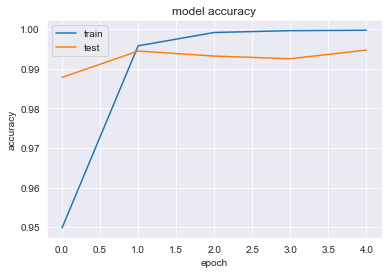

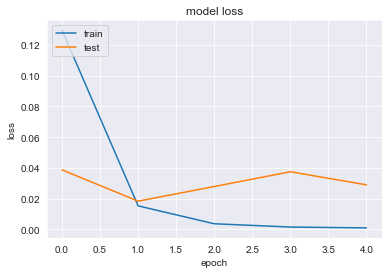

In [23]:
plot_model(model)

In [24]:
submission(model, tokenizer, 'submission_ros.csv')

### SMOTE

In [25]:
data = pd.read_csv('train.csv')
data = data.drop(columns=['id'])

In [26]:
%%time
data['cleaned_tweet'] = data['tweet'].apply(lowercase)
data.head()

CPU times: user 28.4 ms, sys: 219 µs, total: 28.6 ms
Wall time: 29.7 ms


,label,tweet,cleaned_tweet
0,0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation


In [27]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data)

data['cleaned_tweet'] = tokenizer.texts_to_sequences(data['cleaned_tweet'])
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

data['cleaned_tweet'] = pad_sequences(data['cleaned_tweet'], padding='post', maxlen=maxlen)

In [28]:
data_resampled = text_augmentation(data, 'smote')

In [29]:
data_resampled.shape

(59440, 2)

Text(0, 0.5, 'count')

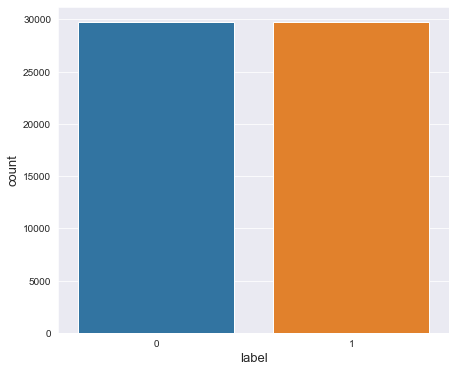

In [30]:
plt.figure(figsize=(7, 6))
sns.countplot(data=data_resampled, x='label')
plt.xlabel('label', fontsize=13)
plt.ylabel('count', fontsize=13)

In [31]:
data_resampled['label'].value_counts()

0    29720
1    29720
Name: label, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled['cleaned_tweet'], 
                                                    data_resampled['label'], 
                                                    test_size=0.2,
                                                    random_state=23)

In [33]:
model = create_model(max_len)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           1996400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           16064     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,012,529
Trainable params: 2,012,529
Non-trainable params: 0
_________________________________________________________________


In [34]:
%%time
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
4756/4756 [==============================] - 135s 28ms/step - loss: 0.6928 - accuracy: 0.5008 - val_loss: 0.6930 - val_accuracy: 0.4997
Epoch 2/5
4756/4756 [==============================] - 135s 28ms/step - loss: 0.6928 - accuracy: 0.5035 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 3/5
4756/4756 [==============================] - 134s 28ms/step - loss: 0.6926 - accuracy: 0.5056 - val_loss: 0.6934 - val_accuracy: 0.4997
Epoch 4/5
4756/4756 [==============================] - 135s 28ms/step - loss: 0.6925 - accuracy: 0.5015 - val_loss: 0.6936 - val_accuracy: 0.4997
Epoch 5/5
4756/4756 [==============================] - 135s 28ms/step - loss: 0.6925 - accuracy: 0.5046 - val_loss: 0.6937 - val_accuracy: 0.5020
CPU times: user 25min 15s, sys: 1min 6s, total: 26min 21s
Wall time: 11min 14s


Training Accuracy: 0.4997
Testing Accuracy:  0.5020


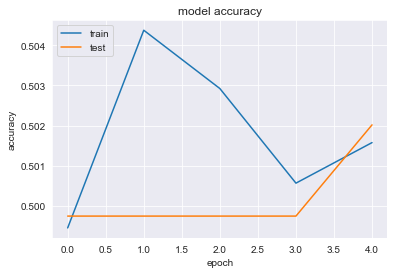

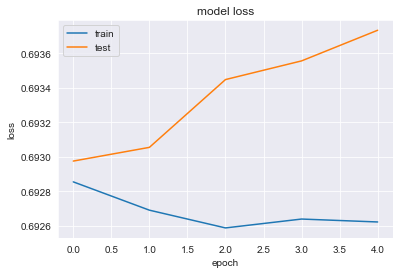

In [35]:
plot_model(model)

In [36]:
submission(model, tokenizer, 'submission_smote.csv')

### SMOTETomek

In [37]:
data = pd.read_csv('train.csv')
data = data.drop(columns=['id'])

In [38]:
%%time
data['cleaned_tweet'] = data['tweet'].apply(lowercase)
data.head()

CPU times: user 27.2 ms, sys: 4.19 ms, total: 31.4 ms
Wall time: 30.5 ms


,label,tweet,cleaned_tweet
0,0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation


In [39]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['cleaned_tweet'])

data['cleaned_tweet'] = tokenizer.texts_to_sequences(data['cleaned_tweet'])
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

data['cleaned_tweet'] = pad_sequences(data['cleaned_tweet'], padding='post', maxlen=maxlen)

In [40]:
data_resampled = text_augmentation(data, 'smotetomek')

In [41]:
data_resampled.shape

(59338, 2)

Text(0, 0.5, 'count')

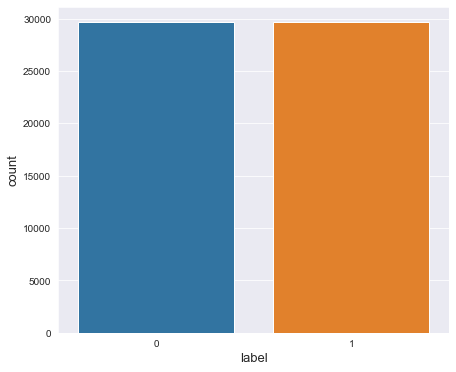

In [42]:
plt.figure(figsize=(7, 6))
sns.countplot(data=data_resampled, x='label')
plt.xlabel('label', fontsize=13)
plt.ylabel('count', fontsize=13)

In [43]:
data_resampled['label'].value_counts()

0    29669
1    29669
Name: label, dtype: int64

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled['cleaned_tweet'],
                                                    data_resampled['label'],
                                                    test_size=0.2,
                                                    random_state=23)

In [45]:
model = create_model(max_len)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           1996400   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 64)           16064     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,012,529
Trainable params: 2,012,529
Non-trainable params: 0
_________________________________________________________________


In [46]:
%%time
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
4747/4747 [==============================] - 134s 28ms/step - loss: 0.5751 - accuracy: 0.6968 - val_loss: 0.5298 - val_accuracy: 0.7265
Epoch 2/5
4747/4747 [==============================] - 136s 29ms/step - loss: 0.5027 - accuracy: 0.7507 - val_loss: 0.5294 - val_accuracy: 0.7260
Epoch 3/5
4747/4747 [==============================] - 133s 28ms/step - loss: 0.4889 - accuracy: 0.7567 - val_loss: 0.5332 - val_accuracy: 0.7254
Epoch 4/5
4747/4747 [==============================] - 133s 28ms/step - loss: 0.4873 - accuracy: 0.7532 - val_loss: 0.5369 - val_accuracy: 0.7290
Epoch 5/5
4747/4747 [==============================] - 133s 28ms/step - loss: 0.4848 - accuracy: 0.7568 - val_loss: 0.5438 - val_accuracy: 0.7252
CPU times: user 25min 12s, sys: 49.2 s, total: 26min 1s
Wall time: 11min 22s


Training Accuracy: 0.7574
Testing Accuracy:  0.7252


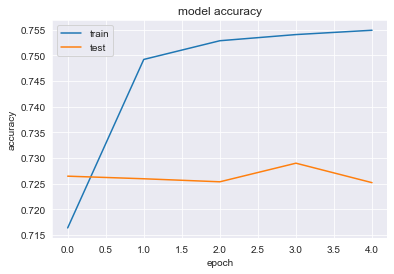

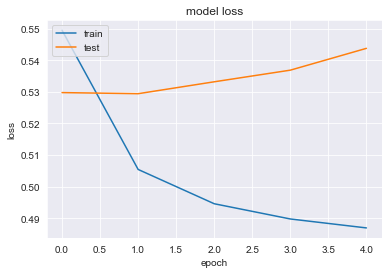

In [47]:
plot_model(model)

In [48]:
submission(model, tokenizer, 'submission_smotetomek.csv')

### NLPAUG

In [49]:
data = pd.read_csv('train.csv')
data = data.drop(columns=['id'])

In [50]:
%%time
data['cleaned_tweet'] = data['tweet'].apply(lowercase)
data.head()

CPU times: user 23.3 ms, sys: 0 ns, total: 23.3 ms
Wall time: 22.4 ms


,label,tweet,cleaned_tweet
0,0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation


In [51]:
data_resampled = text_augmentation(data, 'nlpaug')

In [52]:
data_resampled.shape

(34204, 3)

Text(0, 0.5, 'count')

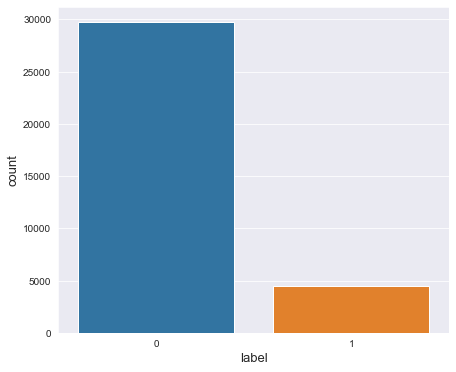

In [53]:
plt.figure(figsize=(7, 6))
sns.countplot(data=data_resampled, x='label')
plt.xlabel('label', fontsize=13)
plt.ylabel('count', fontsize=13)

In [54]:
data_resampled['label'].value_counts()

0    29720
1     4484
Name: label, dtype: int64

In [55]:
data_resampled['cleaned_tweet'] = data_resampled['cleaned_tweet'].apply(str)

In [56]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data_resampled['cleaned_tweet'])

data_resampled['cleaned_tweet'] = tokenizer.texts_to_sequences(data_resampled['cleaned_tweet'])
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

data_resampled['cleaned_tweet'] = pad_sequences(data_resampled['cleaned_tweet'], padding='post', maxlen=maxlen)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled['cleaned_tweet'],
                                                    data_resampled['label'],
                                                    test_size=0.2, 
                                                    random_state=23)

In [58]:
model = create_model(max_len)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           1996400   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 64)           16064     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,012,529
Trainable params: 2,012,529
Non-trainable params: 0
_________________________________________________________________


In [59]:
%%time
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
2737/2737 [==============================] - 79s 28ms/step - loss: 0.2779 - accuracy: 0.9267 - val_loss: 0.2140 - val_accuracy: 0.9345
Epoch 2/5
2737/2737 [==============================] - 77s 28ms/step - loss: 0.1904 - accuracy: 0.9383 - val_loss: 0.2181 - val_accuracy: 0.9350
Epoch 3/5
2737/2737 [==============================] - 77s 28ms/step - loss: 0.1809 - accuracy: 0.9405 - val_loss: 0.2253 - val_accuracy: 0.9352
Epoch 4/5
2737/2737 [==============================] - 77s 28ms/step - loss: 0.1755 - accuracy: 0.9412 - val_loss: 0.2284 - val_accuracy: 0.9350
Epoch 5/5
2737/2737 [==============================] - 77s 28ms/step - loss: 0.1718 - accuracy: 0.9430 - val_loss: 0.2552 - val_accuracy: 0.9350
CPU times: user 14min 37s, sys: 28.5 s, total: 15min 5s
Wall time: 7min 22s


Training Accuracy: 0.9431
Testing Accuracy:  0.9350


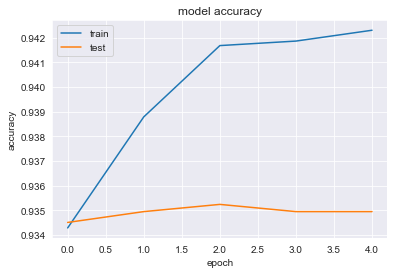

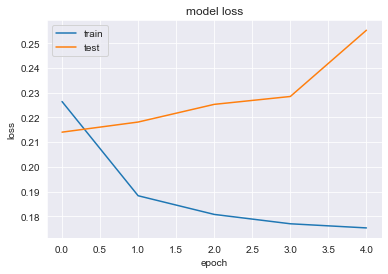

In [60]:
plot_model(model)

In [61]:
submission(model, tokenizer, 'submission_nlpaug.csv')

### EDA

In [62]:
data = pd.read_csv('train.csv')
data = data.drop(columns=['id'])

In [63]:
data = data[data['label'] == 0]

f = open('eda.txt', 'r')

tweets = []
for x in f:
    _, tweet = x.split('\t')
    tweets.append(tweet.strip('\n'))
    
f.close()

negative_tweets = pd.DataFrame({
    'tweet': tweets,
    'label': 1
})

data_resampled = pd.concat([data, negative_tweets], axis=0)
data_resampled.head()
del data, negative_tweets

In [64]:
%%time
data_resampled['cleaned_tweet'] = data_resampled['tweet'].apply(lowercase)
data_resampled.head()

CPU times: user 33.9 ms, sys: 66 µs, total: 34 ms
Wall time: 33.3 ms


,label,tweet,cleaned_tweet
0,0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation


In [65]:
data_resampled.shape

(45414, 3)

Text(0, 0.5, 'count')

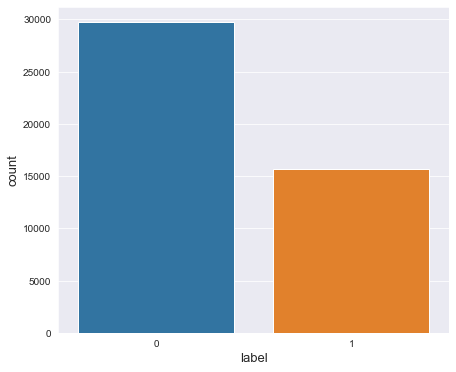

In [66]:
plt.figure(figsize=(7, 6))
sns.countplot(data=data_resampled, x='label')
plt.xlabel('label', fontsize=13)
plt.ylabel('count', fontsize=13)

In [67]:
data_resampled['label'].value_counts()

0    29720
1    15694
Name: label, dtype: int64

In [68]:
data_resampled['cleaned_tweet'] = data_resampled['cleaned_tweet'].apply(str)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled['cleaned_tweet'],
                                                    data_resampled['label'],
                                                    test_size=0.2,
                                                    random_state=23)

In [70]:
X_train, X_test, vocab_size, tokenizer = processing(X_train, X_test)

In [71]:
model = create_model(vocab_size)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           2048850   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 64)           16064     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,064,979
Trainable params: 2,064,979
Non-trainable params: 0
_________________________________________________________________


In [72]:
%%time
history = model.fit(X_train, y_train,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
3634/3634 [==============================] - 115s 31ms/step - loss: 0.2797 - accuracy: 0.8686 - val_loss: 0.0914 - val_accuracy: 0.9651
Epoch 2/5
3634/3634 [==============================] - 114s 31ms/step - loss: 0.0513 - accuracy: 0.9816 - val_loss: 0.0658 - val_accuracy: 0.9753
Epoch 3/5
3634/3634 [==============================] - 114s 31ms/step - loss: 0.0217 - accuracy: 0.9924 - val_loss: 0.0708 - val_accuracy: 0.9781
Epoch 4/5
3634/3634 [==============================] - 113s 31ms/step - loss: 0.0099 - accuracy: 0.9968 - val_loss: 0.0885 - val_accuracy: 0.9756
Epoch 5/5
3634/3634 [==============================] - 113s 31ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0872 - val_accuracy: 0.9790
CPU times: user 21min 30s, sys: 1min 25s, total: 22min 56s
Wall time: 9min 29s


Training Accuracy: 0.9991
Testing Accuracy:  0.9790


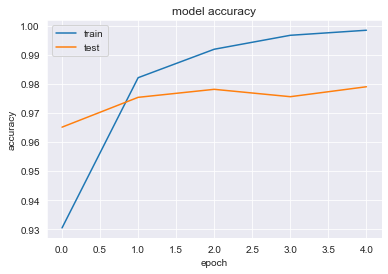

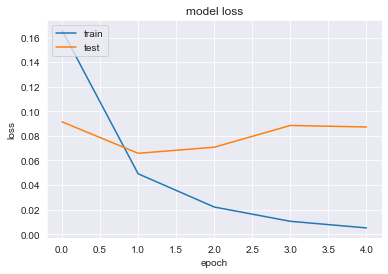

In [73]:
plot_model(model)

In [74]:
submission(model, tokenizer, 'submission_eda.csv')

## Referências

https://realpython.com/python-keras-text-classification/

https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c

https://medium.com/analytics-vidhya/text-classification-from-bag-of-words-to-bert-1e628a2dd4c9

https://nlpforhackers.io/keras-intro/